# This notebook contains the first MODFLOW-CFP model created for Bear Spring on 2/23/23

#### This notebook contains the 10x10 grid CFP (500 iterations) and the initial version of the EPM model at Bear Spring that aggregates all of the galena group into a single layer.

## Import package dependencies

In [37]:
##CFPy Package dependencies
import CFPy as cfpy
import numpy as np
import os
import pandas as pd
import flopy as flopy
import flopy.utils.binaryfile as bf

import glob

#pyKasso2D package dependencies
import pykasso as pk
from matplotlib import pyplot as plt
import matplotlib

In [3]:
##Generate the network structures in pyKasso that will be imported into the model
springshed = pk.SKS(yaml_settings_file="settings_High_Res_10x10_desktop.yaml")

CAUTION: You are using the development version of this package.


## Define helper fxns

In [28]:
def position_to_index(x, y):
    """
    Get the modflow (!) based index for a given geo position
    
    Keyword Arguments
    x -- x position, m
    y -- y position, m
    
    Return
    column index, row index
    """
    
    col_idx = np.floor(x / delr) + 1
    row_idx = n_rows - np.floor(y / delc)
    
    return col_idx, row_idx

def store_results(number):
    """
    Create a directory and put the current results there
    
    Keyword Arguments
    number -- identifier of the current iteration, float or int
    
    Return
    -
    """
    
    # define directory where to store the results
    target_dir = os.path.join(path, f"run_{number}")
    
    # make sure the directory does not exist
    if os.path.exists(target_dir):
        raise Exception(f"Directory {target_dir} exists already! Unable to write results")
        
    # create directory
    os.makedirs(target_dir)
    
    # get alle files that will be moved
    files_to_move = glob.glob("NODE*") + glob.glob("TUBE*") \
                    + [f"{modelname}.list", f"{modelname}.hds", f"{modelname}.cbc"] \
                    + [f"network_{number}.png"] \
                    + glob.glob("*.nbr") + glob.glob("*.coc") + glob.glob("*.cfp") + glob.glob("*.crch")
    
    # move files to directory
    for f in files_to_move:
        source = os.path.join(path, f)
        destination = os.path.join(target_dir, f)
        shutil.move(source, destination)

def clean_results():
    """
    Remove all run-dictionaries
    
    Keyword Arguments
    -
    
    Return
    -
    """    
    run_dirs = glob.glob(os.path.join(path, "run_*"))    
    for rd in run_dirs:
        shutil.rmtree(rd)
        
def plot_network(valid_network, number):
    """
    Plot and save valid network array as png
    
    Keyword Arguments
    valid_network -- valid network array
    number -- identifier of the current iteration, float or int
    
    Return
    -
    """
    
    # create a figure 
    fig = plt.figure(figsize=(10, 10))
    
    # plot the array
    im = plt.imshow(valid_network)
    cb = plt.colorbar(im, shrink=0.3)
    
    # set descriptions
    plt.xlabel("Spaltenindex", size=14)
    plt.ylabel("Reihenindex", size =14)
    cb.set_label("Höhe, m", size=14)
    
    # save figure
    plt.savefig(f'network_{number}.png')

### Build path

In [38]:
## Create the actual modflow model object

#change the active directory to the model directory

#Make the package system independent by using os.path.join everywhere
path = os.getcwd() + '/'
os.chdir(path)

#Set the path to the appropriate yaml file
yaml_file = os.path.join(path) #put the necessary relative path here if needed (mine is in the cwd)

#set the model name
modelname = 'BS_CFP_v1'


#set the path to the CFPv2 executable file
path_to_exe = r"C:\Users\Charlie\CFPy\CFPv2.exe"
mf = flopy.modflow.Modflow(modelname, exe_name=path_to_exe)

## Set up PyKasso params

In [4]:
##import the necessary .csv files for the geology, topography, fractures, sinkholes, springs
##set up the fractures
springshed.set_fractures_mode('image')
springshed.set_fractures_datafile(r'bear_inputs\frac_resized.png')
springshed.update_fractures()

##Set up topography
springshed.set_topography_mode('csv')
springshed.set_topography_datafile(r'bear_inputs\flipped10x10_DEMArray.csv')
springshed.update_topography()

##Set up geology
springshed.set_geological_mode('csv')
springshed.set_geological_datafile(r'bear_inputs\flipped10x10_bedrockArray.csv')
springshed.update_geology()

##Set up inlets (sinkholes, considering 5 traced holes now)
springshed.set_inlets_mode('import')
springshed.set_inlets_data(r'bear_inputs\Traced_Sinkholes.txt')
springshed.update_inlets()

##Set up outlets (springs, considering 3 springs)
springshed.set_outlets_mode('import')
springshed.set_outlets_data(r'bear_inputs\Traced_Springs.txt')
springshed.update_outlets()
##Make sure that other inputs not being considered are turned off
springshed.set_orientation_mode('null')
springshed.update_orientation()
springshed.set_faults_mode('null')
springshed.update_faults()
springshed.set_data_has_polygon(False)
springshed.update_polygon()

In [5]:
##set the conduit generatino parameters
springshed.set_cost_aquifer(0.3)
springshed.set_cost_aquiclude(.6)
springshed.set_cost_fractures(0.1)
springshed.set_cost_conduits(0.1)

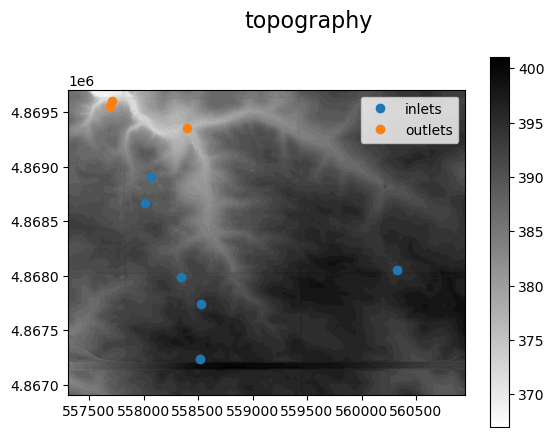

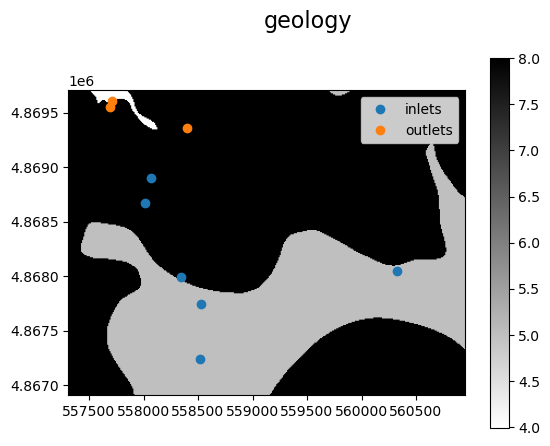

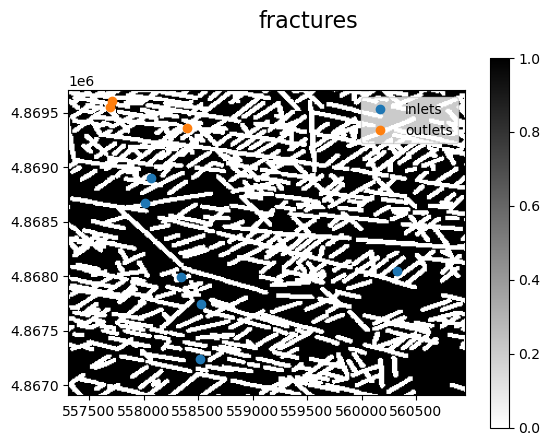

In [6]:
#display different aspects of the springshed model
topography = springshed.get_topography()
springshed.show_catchment(data='topography')
geology = springshed.get_geology()
springshed.show_catchment(data='geology')
fractures = springshed.get_fractures()
springshed.show_catchment(data='fractures')


## Run pyKasso conduit network simulator

In [7]:
##set to the proper solver algorithm
springshed.set_algorithm('Riemann2')#set the appropriate fast marching algorithm, number refers to either 2D or 3D
springshed.update_all()

##Set up iterations
n = 10                                    #number of iterations to calculate (caution: more than 10 is slow)

for i in range(n):
    springshed.update_fractures()
    r = np.random.randint(1,4,(1,3))
    r = np.sort(r)
    springshed.set_outlets_importance(r[0])
    springshed.update_outlets()
    l = np.random.randint(1,6,(1,3))
    l = np.sort(l)
    springshed.set_inlets_per_outlet(l[0])
    springshed.set_inlets_shuffle(True)
    springshed.set_outlets_shuffle(True)
    springshed.update_inlets()
    springshed.update_outlets()
    springshed.compute_karst_network()



 This network contains  1  connected components

Computing:
 - mean length,cv length,length entropy,mean tortuosity

 - orientation entropy,aspl,cpd,md,cv degree,cvd

 This network contains  1  connected components

Computing:
 - mean length,cv length,length entropy,mean tortuosity
 - orientation entropy,aspl,cpd,md,cv degree,cvd

 This network contains  1  connected components

Computing:
 - mean length,cv length,length entropy,mean tortuosity
 - orientation entropy,aspl,cpd,md,cv degree,cvd

 This network contains  1  connected components

Computing:
 - mean length,cv length,length entropy,mean tortuosity

 - orientation entropy,aspl,cpd,md,cv degree,cvd

 This network contains  1  connected components

Computing:
 - mean length,cv length,length entropy,mean tortuosity

 - orientation entropy,aspl,cpd,md,cv degree,cvd

 This network contains  1  connected components

Computing:
 - mean length,cv length,length entropy,mean tortuosity
 - orientation entropy,aspl,cpd,md,cv degree,cvd



## Plot Pykasso Simulation output (single model produced)

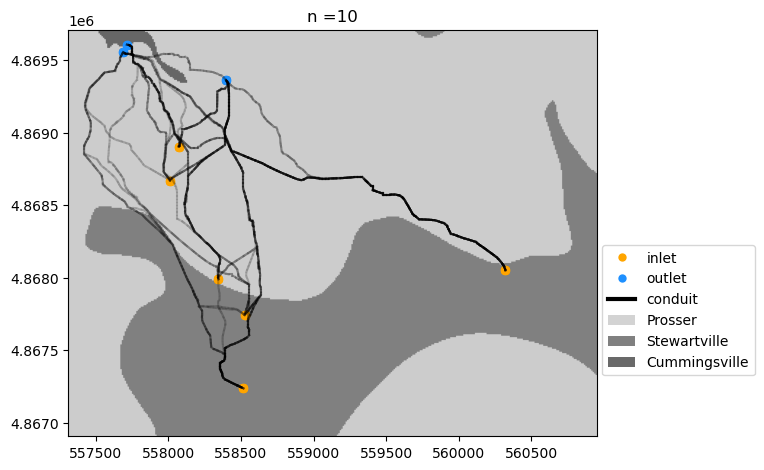

In [8]:
#Display the model for many iterations:
f = plt.figure(figsize=(15,15))

ax = f.add_subplot(121, aspect='equal')
ax.set_title('n ='+str(n))
plt.imshow(springshed.geology.data['geology']['data'], origin='lower', extent=springshed.grid.extent, cmap='gray', vmin=0, vmax=10)
#plt.imshow(springshed._compute_average_paths(), origin='lower', extent=springshed.grid.extent, cmap='gray_r')
for i in range(n):
    springshed.show_network(ax=ax, data=springshed.karst_simulations[i], simplify=False, labels=[], plot_nodes=False, legend=False, color='k', alpha=1/n)

plt.scatter(springshed.inlets[:,0],  springshed.inlets[:,1],  c='orange')
plt.scatter(springshed.outlets[:,0], springshed.outlets[:,1], c='dodgerblue')

legend = [matplotlib.lines.Line2D([0], [0], marker='o', color='none', markerfacecolor='orange', markeredgecolor='none', label='inlet'),
          matplotlib.lines.Line2D([0], [0], marker='o', color='none', markerfacecolor='dodgerblue', markeredgecolor='none', label='outlet'),
          matplotlib.lines.Line2D([0], [0], color='k', lw=3,            label='conduit'),
          matplotlib.patches.Patch(facecolor='lightgray',  label='Prosser'),
          matplotlib.patches.Patch(facecolor='gray',       label='Stewartville'),
          matplotlib.patches.Patch(facecolor='dimgray',    label='Cummingsville')]
plt.legend(handles=legend, loc=[1.01,0.15])

## CFPy-PyKasso Coupling

Use the PyKasso network generated above, couple the conduit network with CFP to have a node-based conduit network. For the first version of this code we are using a single version of the simulated pykasso conduit network

### Set up the appropriate modflow parameters

In [39]:
#import the necessary modflow spatial arrays
## Zones
#Zones: load data from csv files
topo = np.genfromtxt(r'bear_inputs\model_DEM_10x10_smooth.csv', delimiter=',')
ztop = topo.copy()   #create a copy of the topography file
topBedr = np.genfromtxt(r'bear_inputs\model_bedr_topo10x10_smooth.csv', delimiter=',')
ztopBedr = topBedr.copy()
topOSTP = np.genfromtxt(r'bear_inputs\model_OSTP_top_10x10.csv', delimiter=',')
ztopOSTP = topOSTP.copy()
botOSTP = np.genfromtxt(r'bear_inputs\Model_OSTP_Botm_10x10.csv', delimiter=',')   #load bottom elevation of model from csv file
zbotOSTP = botOSTP.copy()

#### Spatial Domain Characteristics

In [50]:
# Defining the spatial domain characteristics
#NOTE: n_rows, n_cols, n_lays needs to be the same as specified in the .nbr file!
#TODO: Use nrow, ncol etc. from FloPy also in CFPy

#matrix dimensions
# number of rows, columns, and layers, in the domain, int
n_rows = 280
n_cols = 364
n_lays = 3    ##NEED TO CONFIRM IF THIS IS HOW I AM SETTING UP THE NBR FILE
#width of each cell along rows/columns
delr = 10
delc = 10

#layer properties from original flopy Bear Spring Model
layers = np.arange(n_lays)
topm = ztop ##surface topography csv
botm = np.full((n_lays,n_rows,n_cols), ztopBedr)  #make an array of default cell bottom elevations for each cell
laytyp = [1,1,1] #whether each layer is confined or unconfined
laycbd = [0,0,1] #whether or not each layer has a confining unit beneath it
botm[0,:,:] = ztopBedr-1 #subtracting 1 from the bedrock array to avoid convergence errors, same as DEM in some places (thin soils)
botm[1,:,:] = ztopOSTP
botm[2,:,:] = zbotOSTP

#layer elevations [top, bottom] [m,m] ##3 layers, each needs to be a 3D array to be non-planar (cell-by-cell elevations)
#1st layer: unconsolidated, 2nd layer: Aggregate of Galena limestones, 3rd layer: OSTP (for now)

### IMPORTANT, must be an array of FLOATS not ints
lay_elevs = [[topm, botm[0]],[botm[0],botm[1]],[botm[1],botm[2]]]



#### Hydraulic characteristics

In [51]:
#hydraulic characteristics from the original flopy model
#horizontal and vertical hydraulic conductivity of the porous matrix[L/T]
Kx = np.full((n_lays,n_rows,n_cols), 1e-2) # create an array of default hydraulic conductivities
Kx[0,:,:] = 1e-2
Kx[1,:,:] = 5e-1
Kx[2,:,:] = 1e-6
K_ratio = 1            #ratio of Ky/Kx, if =1 then the hydraulic conductivities are the same in both horizontal directions

#Kz:
Kz = np.full((n_lays,n_rows,n_cols),5e-2)
Kz[0,:,:] = 1e-2
Kz[0,:,:] = 1
Kz[0,:,:] = 1e-6

## Storage and specific yield
Ss= 0.0001 #storage coefficient, water released from compaction
Sy = 0.1   #specific yield (water released from desaturation)

#### Time and space Discretization

In [45]:
#time units:1=seconds, 2= minutes, 3=hours, 4=days. 5= year
time_unit = 5
#length units, 1:ft, 2:meters
lenuni = 2 

#length (number of steps) of stress periods
# this variable assumes a uniform time discretization, that all stress periods have the same number
# of time steps except for the first stationary time step
perlen = 1

#number of time steps in each of the stress periods (integer arrray)
# e.g. [1,50,50,70,33,...]
n_stps=[perlen]

#list with "False" everywhere except for the 0th element (which is "True")
    # to specify steady state ("True") or transient ("False")
    # stress periods
steady=[1]

#### Hydraulic boundary conditions (fixed and initial)

In [66]:
# recharge to the whole area, mm/a
reacharge_wholearea =890.6

#defined head of the leftmost column, m
chb_left = np.full((n_lays, n_rows, n_cols), ztop-8)

#defined head at spring node, m
chb_spring = 372

#matrix starting head, m
H_init = np.full((n_lays, n_rows, n_cols), ztop-8)  # array of initial heads in each cell set to 8m below the land surface elevation

#### Solver Tolerances

In [53]:
#modflow general tolerance
mftol = 1e-3

#modflow relaxation parameter
cfptol = 1e-6

#CFP general tolerance
cfptol = 1e-6

#CFP relaxation parameter
cfprelax= .99

#### CFP Variables

In [79]:
#Geo position of spring, only change with settings.yaml!
x_spring = [np.floor((557714-557316.637600)/10)]
y_spring = [np.floor((4869606-4866912.839400)/10)]


# elevation of all nodes, m
#simulating the elevations of the conduit nodes with a linear elevation, certainly not correct
# Elevation data must have the same shape as the node network array!

#Get shape
domain_shape = np.shape(np.array(springshed.karst_simulations[-1].maps['karst'][-1]))
#make linearly spaced values along a single column
elevs = np.linspace(380., topm_avg, domain_shape[0], endpoint=True)
#repeat values and reshape to the desired shape
elevs = np.repeat(elevs, domain_shape[1],0).reshape(domain_shape)

#pipe diameter, m
diameter = 0.6  # this is a guess, not sure if there is any more reliable data available to improve this 

# pipe tortuosity
tortuosity = 1.5  # take from this literature values regarding Bear Spring Tortuosity

#roughness height, m
rheight = .02   #not sure what type of data we will have available for this

#lower critical reynolds number
lcritrey = 2000

#higher critical reynolds number
hcritrey = 5000

#conduit wall conductivity, m^2/s
k_exchange = .3

#Conduit associated drainable storage (CADS), m
cad = 0.00

#### Derived Variables

In [76]:
#Get the modflow indices for the spring(s)
#col_idx_spring, row_idx_spring = position_to_index(x_spring, y_spring)  ## This will not work with multiple springs, 
#likely need to just have BS

#compute total length along x
Lx = n_cols * delr
#compute total length along y
Ly = n_rows * delc

#expand elevations to array
lay_elevs_array = [np.ones((n_rows, n_cols)) * lay_elevs[0],
                   np.ones((n_rows, n_cols)) * lay_elevs[1],
                   np.ones((n_rows, n_cols)) * lay_elevs[2]]

#### Averaging layer elevations for simplified model (may or may not be used)

In [19]:
#Get average elevations from each layer
topm_avg = np.mean(topm)
topm_stdv = np.std(topm)
topBedr_avg = np.mean(botm[0,:,:])
topBedr_stdv = np.std(botm[0,:,:])
topOSTP_avg = np.mean(botm[1,:,:])
topOSTP_stdv = np.std(botm[1,:,:])
botOSTP_avg = np.mean(botm[2,:,:])
botOSTP_stdv = np.std(botm[2,:,:])

print(f"Average Topm: {topm_avg}, std dev topm: {topm_stdv}")
print(f"Average TopBedr: {topBedr_avg}, std dev topm: {topBedr_stdv}")
print(f"Average TopOSTP: {topOSTP_avg}, std dev topm: {topOSTP_stdv}")
print(f"Average botOSTP: {botOSTP_avg}, std dev topm: {botOSTP_stdv}")

Average Topm: 391.37269987609193, std dev topm: 4.896650748552569
Average TopBedr: 386.7175548477612, std dev topm: 4.863535081340839
Average TopOSTP: 330.2050039246468, std dev topm: 0.9194322440919519
Average botOSTP: 302.50031397174257, std dev topm: 1.6182400450294674


## Remove prior results

In [71]:
clean_results()

### Make the PyKasso Network quasi-3D


Always visually check the validated network for structuralcorrectness! 
i.e., whether branches are correctly isolated or ifthey got connected during processing.


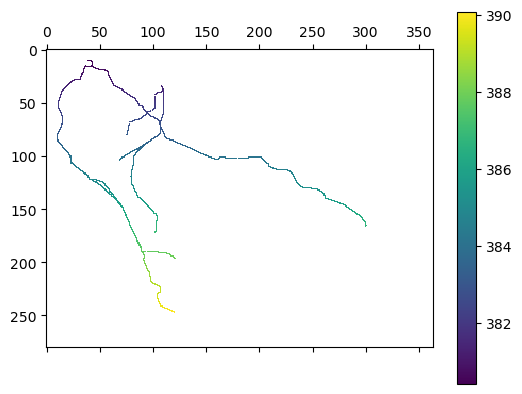

In [72]:
##Issue discovered. Because the model is actually based on UTMN and UTME coordinates(such as the spring/sinkhole coords
#there is an issue when the validator goes to check the locations of the inlet/outlet nodes)
##IMPORTANT: Local fix implemented on 3/13/23. changes passed to Max Rudolph at TU Dresden for github implementation

#validate the network using the CFPy validator
validator = cfpy.preprocessing.pyKassoValidator(network=springshed, elevations=elevs)
valid_network = validator.validate_network()

# export the network
# the exported information can directly be included in the .nbr-file as input for CFPy
# notes on how to use the generated data with CFPy is given at the end of the notebook
path = os.path.join(os.getcwd(), 'network_plane_{}.txt')
validator.export_network(path)


#plot the network and mask 0.-values(they would screw up the coloring)
im = plt.matshow(np.where(valid_network== 0., np.nan,  valid_network))
plt.colorbar(im)

validator.generate_nbr(path=None, nplanes=2, nrows=n_rows, ncols=n_cols, nlays=n_lays, layer_elevations=[[topm_avg],[topBedr_avg],[topOSTP_avg],[botOSTP_avg]])

### CFPy-Generate the NBR input for CFPv2

In [31]:
## Initialize the nbr module

#NOTE:There should only ever be a single .nbr file in the active domain, if there is not a .nbr file
## or there are multiple .nbr-files present CFPy will throw an error

nbr = cfpy.nbr()

# bot_elev has shape (n_layers, n_rows, n_cols)
# cond_elev has shape (n_conduit_layers, n_rows, n_cols)

bot_elev, cond_elev = nbr.nbr_read()

#create the nbr-data
nbr_data = nbr.nbr(bot_elev, cond_elev)

Elapsed time (.nbr file read): 0.02 s
Elapsed time (write nbr data): 4.4 s


## Plot the network

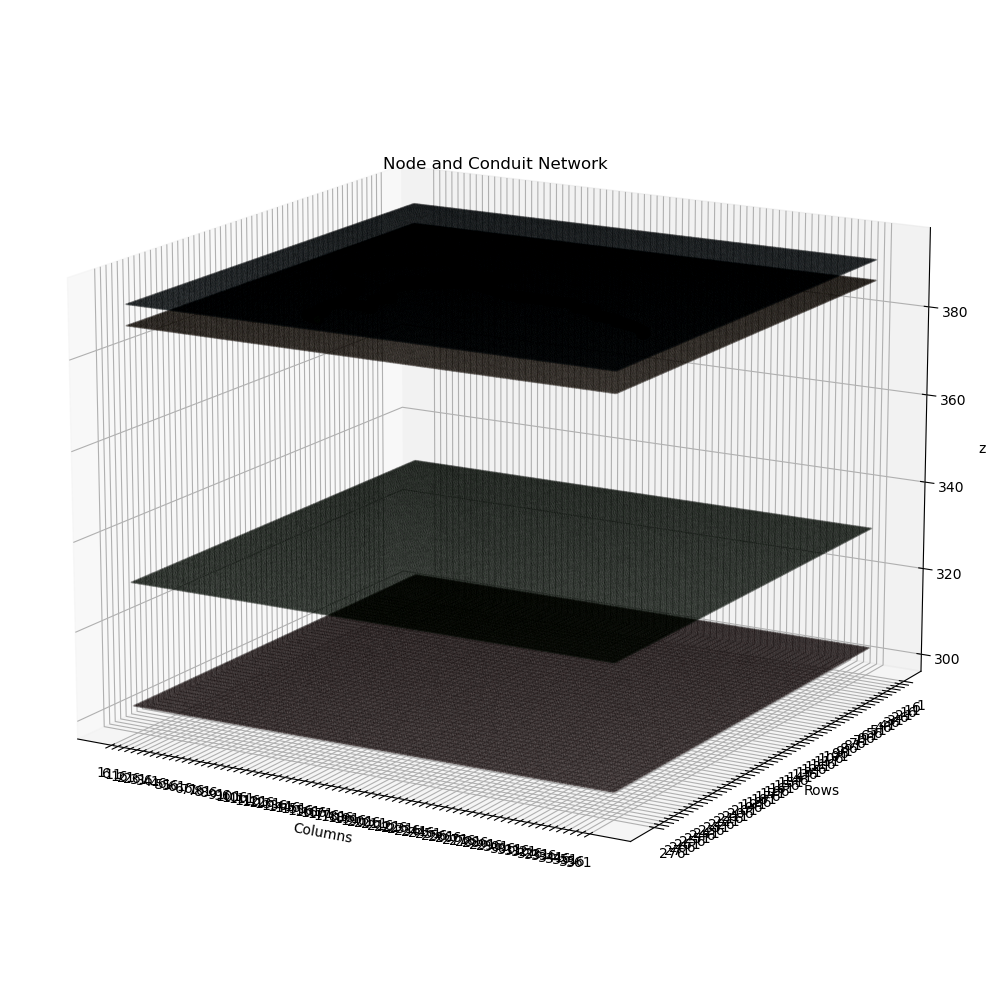

In [32]:
network = cfpy.plots.Network(elevs=[bot_elev, cond_elev], nbr_data=nbr_data)
plot = network.plot_network(text_shift=0.1, dpi=100, rot_x=15, rot_z=-60, plot_nums=False, kind="triangular")
#plt.savefig("network.jpg", dpi=600)